<a href="https://colab.research.google.com/github/kartikeyahl/MS_analysis/blob/main/PunchTimeAnalysisLatest5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import math
import concurrent.futures as ft
import multiprocessing

In [2]:
# Importing the excel
def loadData():
  global dataset,dataset2,dataset3
  # !unzip punch_short.xlsx
  dataset = pd.read_excel('punch_short.xlsx',parse_dates=['Date'],
      date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d'))
  dataset2=pd.read_excel('Master Data.xlsx')
  dataset3=pd.read_excel('Shift_Timings.xlsx')

with ft.ThreadPoolExecutor() as executor:
  executor.submit(loadData)

In [3]:
#Renaming column name to a valid column name format as per python
dataset.rename(columns={'IN/OUT': 'IN_OUT'}, inplace=True)

In [4]:
#Droping rows that conatain 1 in 'IN_OUT' column
dataset=dataset[dataset.IN_OUT!=1]

In [5]:
dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce')
# dataset3['date'] = pd.to_datetime(dataset3['date'], errors='coerce')

<ipython-input-5-e70d293d76f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce')


In [6]:
dataset.dropna(inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [7]:
a1=str(dataset.iloc[0]['Date'])
a2=str(dataset.iloc[-1]['Date'])
d1 = datetime.strptime(a1[0:10], "%Y-%m-%d")
d2 = datetime.strptime(a2[0:10], "%Y-%m-%d")
date_diff = abs((d2 - d1).days)+1  

In [8]:
#Calculating and appending Punch time difference for each employee with the corresponding E.Code into dataframe (l)
l_shift=[]
for i in range(len(dataset3)):
  x_=str(int(dataset3.iloc[i]['Start']))
  y_=str(int(dataset3.iloc[i]['End']))

  if len(x_)<=5:
    x_=x_.zfill(6)
  if len(y_)<=5:
    y_=y_.zfill(6)

  x_ = datetime.strptime(x_, "%H%M%S")
  x_.strftime("%I:%M %p")
  y_ = datetime.strptime(y_, "%H%M%S")
  y_.strftime("%I:%M %p")

  presentday = pd.to_datetime('20221001', errors='coerce')
  tomorrow = pd.to_datetime('20221002', errors='coerce')
  if dataset3.iloc[i]['End date']=='same':
    l_shift.append([datetime.combine(presentday, y_.time()) - datetime.combine(presentday, x_.time())])
  else:
    l_shift.append([datetime.combine(tomorrow, y_.time()) - datetime.combine(presentday, x_.time())])    

In [9]:
#Calculating and appending Punch time difference for each employee with the corresponding E.Code into dataframe (l)
def punchtimeDifference(dataset):
  l=[]
  for i in range(len(dataset)-1):
    j=i+1
    x=str(int(dataset.iloc[i]['Time']))
    y=str(int(dataset.iloc[j]['Time']))
    if len(x)<=5:
      x=x.zfill(6)
    if len(y)<=5:
      y=y.zfill(6)

    x = datetime.strptime(x, "%H%M%S")
    x.strftime("%I:%M %p")
    y = datetime.strptime(y, "%H%M%S")
    y.strftime("%I:%M %p")
    l.append([dataset.iloc[i]['E.Code'], dataset.iloc[i]['Date'].date(), dataset.iloc[i]['IN_OUT'], int(dataset.iloc[i]['Time']), datetime.combine(dataset.iloc[j]['Date'], y.time()) - datetime.combine(dataset.iloc[i]['Date'], x.time()),dataset.iloc[i]['Location']])  
    i=i+2
  return l

with ft.ProcessPoolExecutor() as executor:
  l=executor.submit(punchtimeDifference,dataset).result()

In [10]:
#Replacing ":" with "." and getting upto 2 decimal places in Time to make mathematical operations feasible on i
for i in range(len(l)):
  l[i][4] = l[i][4].__str__().replace(":",".")
  s=l[i][4]
  l[i][4]=s[0:-3]

for i in range(len(l_shift)):
  l_shift[i][0] = l_shift[i][0].__str__().replace(":",".")
  s=l_shift[i][0]
  l_shift[i][0]=float(s[0:-3])

In [11]:
data3= pd.DataFrame(l_shift,columns=['Difference'])
dataset3= pd.concat([dataset3,data3],axis=1)

In [12]:
#Removing redundant rows and storing in new data-structure
l2=[]
for i in range(len(l)):
  if 'P20' not in str(l[i][2]):
    l2.append(l[i]) 

In [13]:
for i in range(len(l2)):
  if 'd' in l2[i][4]:
    s=l2[i][4]
    s=float(s[7:len(s)])
    l2[i][4]=24+s

In [14]:
#Converting string type to float for Time column
for i in range(len(l2)):
  try:
   l2[i][4]=float("{:.2f}".format(float(l2[i][4])))
  except:                      
    pass

for i in range(len(l2)):
  try:
   l2[i][4]=float("{:.2f}".format(float(l2[i][4])))
  except:                      
    pass

In [15]:
"""Converting time from float to mins, applied logic to check if it is greater than 9hrs & 30mins. Subtacting the 
result to get over time (minutes) converting and storing it into hrs.minutes format. """
def punchLocation(l2,dataset3):
  l3=[]
  for i in range(len(l2)):  
    frac, whole = math.modf(l2[i][4])
    mins=int(whole*60+frac*100)

    try:
      #1F A-Shift
      if (dataset3.iloc[0]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[0]['Start']-3000) and '1F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[0]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #1F B-Shift
      elif (dataset3.iloc[1]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[1]['Start']-3000) and '1F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[1]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #1F C-Shift
      elif (dataset3.iloc[2]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[2]['Start']-3000) and '1F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[2]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #HO G-Shift
      elif (dataset3.iloc[15]['Start']+10000)>=l2[i][3]>=(dataset3.iloc[15]['Start']-10000) and 'Head' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[15]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #2F A-Shift
      elif (dataset3.iloc[3]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[3]['Start']-3000) and '2F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[3]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #2F B4-Shift
      elif (dataset3.iloc[4]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[4]['Start']-3000) and '2F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[4]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #2F C-Shift
      elif (dataset3.iloc[5]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[5]['Start']-3000) and '2F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[5]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #2F G-Shift
      elif (dataset3.iloc[6]['Start']+10000)>=l2[i][3]>=(dataset3.iloc[6]['Start']-10000) and '2F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[6]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #3F A-Shift
      elif (dataset3.iloc[7]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[7]['Start']-3000) and '3F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[7]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #3F B4-Shift
      elif (dataset3.iloc[8]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[8]['Start']-3000) and '3F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[8]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #3F C-Shift
      elif (dataset3.iloc[9]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[9]['Start']-3000) and '3F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[9]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #3F G-Shift
      elif (dataset3.iloc[10]['Start']+10000)>=l2[i][3]>=(dataset3.iloc[10]['Start']-1000) and '3F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[10]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #4F A-Shift
      elif (dataset3.iloc[11]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[11]['Start']-3000) and '4F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[11]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #4F B-Shift
      elif (dataset3.iloc[12]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[12]['Start']-3000) and '4F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[12]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #4F C-Shift
      elif (dataset3.iloc[13]['Start']+1500)>=l2[i][3]>=(dataset3.iloc[13]['Start']-3000) and '4F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[13]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

      #4F G-Shift
      elif (dataset3.iloc[14]['Start']+10000)>=l2[i][3]>=(dataset3.iloc[14]['Start']-10000) and '4F' in l2[i][5]:
        frac1, whole1 = math.modf(dataset3.iloc[14]['Difference'])
        mins_dif=int(whole1*60+frac1*100)
        mins_dif+=30
        if mins>mins_dif:
          mins=mins-mins_dif
          hours=mins//60
          minutes=mins%60
          if minutes<10:
            ot_time = float("{}.0{}".format(hours, minutes))
          elif minutes%10==0:
            ot_time = float("{}.{}0".format(hours, minutes))
          else:
            ot_time = float("{}.{}".format(hours, minutes))
          l2[i]=l2[i][:-1]
          l2[i].append(ot_time)
          l3.append(l2[i])

    except:
      pass
  return l3

with ft.ProcessPoolExecutor() as executor:
  l3=executor.submit(punchLocation,l2,dataset3).result()

In [16]:
#Removing redundant rows and storing in new data-structure
l4=[]
for i in range(len(l3)):
  if l3[i][5]>0:
    l4.append(l3[i]) 

In [17]:
for i in range(len(l4)):
  if len(l4[i])==7:
    print(l4[i][0],l4[i][1],l4[i][2],l4[i][3],l4[i][4],l4[i][5],l4[i][6])

In [18]:
# Converting 2d list to dataframe to apply CRUD opertations
df = pd.DataFrame(l4, columns=['E.Code','Date','IN/OUT','Time','Total Time','OT'])

In [19]:
df_copy=df.copy(deep=True)

In [20]:
#Droping an unnecesary column
df=df.drop(['IN/OUT','Time','Total Time'], axis=1)

In [21]:
ll1=[]
def binarySearch(arr, l, r, x):

	while l <= r:

		mid = l + (r - l) // 2

		# Check if x is present at mid
		if arr[mid] == x:
			return mid

		# If x is greater, ignore left half
		elif arr[mid] < x:
			l = mid + 1

		# If x is smaller, ignore right half
		else:
			r = mid - 1

	# If we reach here, then the element
	# was not present
	return -1


# Driver Code
arr = [int(i) for i in dataset2['E Code']]

for i in range(len(df)):
  # Function call
  result = binarySearch(arr, 0, len(arr)-1, df.iloc[i]['E.Code'])

  if result != -1:
      ll1.append([dataset2.iloc[result]['Full Name'], dataset2.iloc[result]['Designation'],dataset2.iloc[result]['Location'],dataset2.iloc[result]['Operation'],dataset2.iloc[result]['Division'],dataset2.iloc[result]['Department']])
  else:
      ll1.append(['NaN','NaN','NaN','NaN','NaN','NaN'])


In [22]:
# Converting 2d list to dataframe to apply CRUD opertations
dff = pd.DataFrame(ll1, columns=['Full Name','Designation','Location','Operation','Division','Department'])

In [23]:
df_final = pd.concat([df['E.Code'], dff, df[['Date','OT']]], axis=1)

In [24]:
#double shift
l_double_shift=[]
for i in range(len(df_copy)):
  if df_copy.iloc[i]['Time']>53000 and df_copy.iloc[i]['Time']<63000:
    if df_copy.iloc[i]['Total Time']>=17.50:
      l_double_shift.append([df_copy.iloc[i]['E.Code'],df_copy.iloc[i]['Date'],'A-B'])
  elif df_copy.iloc[i]['Time']>143000 and df_copy.iloc[i]['Time']<150000:
    if df_copy.iloc[i]['Total Time']>=15.50:
      l_double_shift.append([df_copy.iloc[i]['E.Code'],df_copy.iloc[i]['Date'],'B-C'])
  elif df_copy.iloc[i]['Time']>230000 and df_copy.iloc[i]['Time']<234000:
    if df_copy.iloc[i]['Total Time']>=15.50:
      l_double_shift.append([df_copy.iloc[i]['E.Code'],df_copy.iloc[i]['Date'],'C-A'])

def binarySearch(arr, l, r, x):
	while l <= r:

		mid = l + (r - l) // 2

		# Check if x is present at mid
		if arr[mid] == x:
			return mid

		# If x is greater, ignore left half
		elif arr[mid] < x:
			l = mid + 1

		# If x is smaller, ignore right half
		else:
			r = mid - 1

	# If we reach here, then the element
	# was not present
	return -1

arr = [int(i) for i in dataset2['E Code']]
for i in range(len(l_double_shift)):
  # Function call
  result = binarySearch(arr, 0, len(arr)-1, l_double_shift[i][0])

  if result != -1:
      l_double_shift[i].append(dataset2.iloc[result]['Full Name'])
      l_double_shift[i].append(dataset2.iloc[result]['Designation'])
      l_double_shift[i].append(dataset2.iloc[result]['Location'])
      l_double_shift[i].append(dataset2.iloc[result]['Operation'])
      l_double_shift[i].append(dataset2.iloc[result]['Division'])
      l_double_shift[i].append(dataset2.iloc[result]['Department'])
  else:
      l_double_shift[i].append('NaN')
      l_double_shift[i].append('NaN')
      l_double_shift[i].append('NaN')
      l_double_shift[i].append('NaN')
      l_double_shift[i].append('NaN')
      l_double_shift[i].append('NaN')

In [25]:
l_double_shift = pd.DataFrame(l_double_shift,columns=['E.Code','Date','Double-Shift','Full Name','Designation','Location','Operation','Division','Department'])

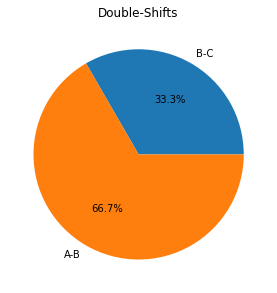

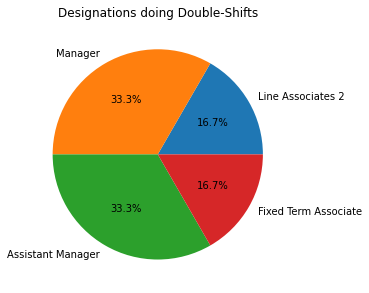

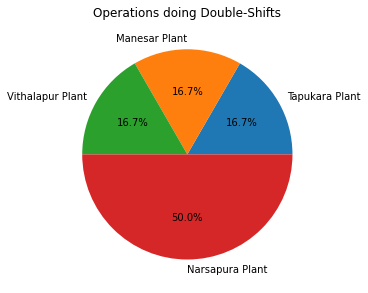

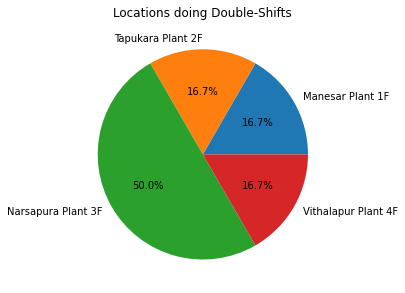

In [29]:
if len(l_double_shift['Double-Shift'])>1:
  l_double_shift_list = list(set(l_double_shift['Double-Shift']))
  count_Double_Shift=[]
  count_Double_Shift=[list(l_double_shift['Double-Shift']).count(l_double_shift_list[i]) for i in range(len(l_double_shift_list))]
  x = l_double_shift_list
  plt.figure(figsize=(10, 5))  
  plt.pie(count_Double_Shift,labels=x,autopct='%1.1f%%')
  plt.title('Double-Shifts')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('doubleshiftgraph.png',bbox_inches="tight")
  

if len(l_double_shift['Designation'])>1:
  l_double_shift_list = list(set(l_double_shift['Designation']))
  count_Double_Shift=[]
  count_Double_Shift=[list(l_double_shift['Designation']).count(l_double_shift_list[i]) for i in range(len(l_double_shift_list))]
  x = l_double_shift_list
  plt.figure(figsize=(10, 5))  
  plt.pie(count_Double_Shift,labels=x,autopct='%1.1f%%')
  plt.title('Designations doing Double-Shifts')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('doubleshiftgraph2.png',bbox_inches="tight")


if len(l_double_shift['Operation'])>1:
  l_double_shift_list = list(set(l_double_shift['Operation']))
  count_Double_Shift=[]
  count_Double_Shift=[list(l_double_shift['Operation']).count(l_double_shift_list[i]) for i in range(len(l_double_shift_list))]
  x = l_double_shift_list
  plt.figure(figsize=(10, 5))  
  plt.pie(count_Double_Shift,labels=x,autopct='%1.1f%%')
  plt.title('Operations doing Double-Shifts')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('doubleshiftgraph3.png',bbox_inches="tight")


if len(l_double_shift['Location'])>1:
  l_double_shift_list = list(set(l_double_shift['Location']))
  count_Double_Shift=[]
  count_Double_Shift=[list(l_double_shift['Location']).count(l_double_shift_list[i]) for i in range(len(l_double_shift_list))]
  x = l_double_shift_list
  plt.figure(figsize=(10, 5))  
  plt.pie(count_Double_Shift,labels=x,autopct='%1.1f%%')
  plt.title('Locations doing Double-Shifts')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('doubleshiftgraph4.png',bbox_inches="tight")


In [31]:
df_final_hr_min=df_final.copy(deep=True)
l_time1=[]
for i in df_final_hr_min.index:
      minutes, hours = math.modf(df_final_hr_min['OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time1.append(ot_time)
df_final_hr_min.drop(['OT'],axis=1)
df_final_hr_min['OT']=l_time1

In [32]:
""" Applying Groupby opr. to group dataframe on basis of E.Code and apply sum and count opr. to 
compute Total_OT & Total_OT_Days """

groupby_ecode_Total_OT = df.groupby(['E.Code'],as_index=False).sum()
groupby_ecode_Total_OT_Days = df.groupby(['E.Code'],as_index=False).count()
groupby_operation_sum = df_final.groupby(['Operation'],as_index=False).sum()
groupby_operation = df_final.groupby(['Operation'],as_index=False).count()
groupby_division_sum = df_final.groupby(['Division'],as_index=False).sum()
groupby_division = df_final.groupby(['Division'],as_index=False).count()
groupby_designation_sum = df_final.groupby(['Designation'],as_index=False).sum()
groupby_designation = df_final.groupby(['Designation'],as_index=False).count()
groupby_location_sum = df_final.groupby(['Location'],as_index=False).sum()
groupby_location = df_final.groupby(['Location'],as_index=False).count()
groupby_dept_sum = df_final.groupby(['Department'],as_index=False).sum()
groupby_dept = df_final.groupby(['Department'],as_index=False).count()

In [33]:
grp_opr = pd.DataFrame(df_final.groupby(['Operation','E.Code'],as_index=False).size())
grp_des = pd.DataFrame(df_final.groupby(['Designation','E.Code'],as_index=False).size())
grp_div = pd.DataFrame(df_final.groupby(['Division','E.Code'],as_index=False).size())
grp_loc = pd.DataFrame(df_final.groupby(['Location','E.Code'],as_index=False).size())
grp_dept = pd.DataFrame(df_final.groupby(['Department','E.Code'],as_index=False).size())

In [34]:
grp_opr_count=[]
for i in range(len(grp_opr)):
  grp_opr_count.append(grp_opr.iloc[i]['Operation'])

grp_des_count=[]
for i in range(len(grp_des)):
  grp_des_count.append(grp_des.iloc[i]['Designation'])

grp_div_count=[]
for i in range(len(grp_div)):
  grp_div_count.append(grp_div.iloc[i]['Division'])

grp_loc_count=[]
for i in range(len(grp_loc)):
  grp_loc_count.append(grp_loc.iloc[i]['Location'])
  
grp_dept_count=[]
for i in range(len(grp_dept)):
  grp_dept_count.append(grp_dept.iloc[i]['Department'])

In [35]:
import collections
# initializing dict to store frequency of each element
grp_opr_count_array = []
grp_opr_count_dict = collections.Counter(grp_opr_count)

grp_des_count_array = []
grp_des_count_dict = collections.Counter(grp_des_count)

grp_div_count_array = []
grp_div_count_dict = collections.Counter(grp_div_count)

grp_loc_count_array = []
grp_loc_count_dict = collections.Counter(grp_loc_count)

grp_dept_count_array = []
grp_dept_count_dict = collections.Counter(grp_dept_count)

In [36]:
grp_opr_count_array = list(grp_opr_count_dict.values())
grp_opr_count_dataframe=pd.DataFrame(grp_opr_count_array,columns=['Number of associates'])

grp_des_count_array = list(grp_des_count_dict.values())
grp_des_count_dataframe=pd.DataFrame(grp_des_count_array,columns=['Number of associates'])

grp_div_count_array = list(grp_div_count_dict.values())
grp_div_count_dataframe=pd.DataFrame(grp_div_count_array,columns=['Number of associates'])

grp_loc_count_array = list(grp_loc_count_dict.values())
grp_loc_count_dataframe=pd.DataFrame(grp_loc_count_array,columns=['Number of associates'])

grp_dept_count_array = list(grp_dept_count_dict.values())
grp_dept_count_dataframe=pd.DataFrame(grp_dept_count_array,columns=['Number of associates'])

In [37]:
Operation_count = pd.DataFrame(df_final.groupby(['Operation'],as_index=False).size())
Division_count = pd.DataFrame(df_final.groupby(['Division'],as_index=False).size())
Designation_count = pd.DataFrame(df_final.groupby(['Designation'],as_index=False).size())
Location_count = pd.DataFrame(df_final.groupby(['Location'],as_index=False).size())
Department_count = pd.DataFrame(df_final.groupby(['Department'],as_index=False).size())

In [38]:
#Converting Groupby object into DataFrame to apply CRUD opr.
df2=pd.DataFrame(groupby_ecode_Total_OT)
df3=pd.DataFrame(groupby_ecode_Total_OT_Days)
df4=pd.DataFrame(groupby_operation)
df5=pd.DataFrame(groupby_division)
df6=pd.DataFrame(groupby_operation_sum)
df7=pd.DataFrame(groupby_division_sum)
df8=pd.DataFrame(groupby_designation)
df9=pd.DataFrame(groupby_designation_sum)
df10=pd.DataFrame(groupby_location)
df11=pd.DataFrame(groupby_location_sum)
df12=pd.DataFrame(groupby_dept)
df13=pd.DataFrame(groupby_dept_sum)

In [39]:
df4=df4.drop(['E.Code','Full Name','Designation','Location','Division','Department','Date'], axis=1)
df5=df5.drop(['E.Code','Full Name','Designation','Location','Operation','Department','Date'], axis=1)
df8=df8.drop(['E.Code','Full Name','Location','Operation','Division','Department','Date'], axis=1)
df10=df10.drop(['E.Code','Full Name','Designation','Operation','Division','Department','Date'], axis=1)
df12=df12.drop(['E.Code','Full Name','Designation','Location','Operation','Division','Date'], axis=1)

df6=df6.drop(['E.Code'], axis=1) 
df7=df7.drop(['E.Code'], axis=1)
df9=df9.drop(['E.Code'], axis=1)
df11=df11.drop(['E.Code'], axis=1)
df13=df13.drop(['E.Code'], axis=1)

In [40]:
df4.rename(columns={'OT': 'Total OT_Days'}, inplace=True)
df5.rename(columns={'OT': 'Total OT_Days'}, inplace=True)
df8.rename(columns={'OT': 'Total OT_Days'}, inplace=True)
df10.rename(columns={'OT': 'Total OT_Days'}, inplace=True)
df12.rename(columns={'OT': 'Total OT_Days'}, inplace=True)
# df6.rename(columns={'OT': 'Total OT_Days'}, inplace=True)
# df7.rename(columns={'OT': 'Total OT_Days'}, inplace=True)

In [41]:
l4=[]
for i in df2.index:
      frac, whole = math.modf(df2['OT'][i])
      mins=int(whole*60+frac*100)
      hours=mins//60
      minutes=mins%60
      if minutes<10:
          ot_time = float("{}.0{}".format(hours, minutes))
      elif minutes%10==0:
        ot_time = float("{}.{}0".format(hours, minutes))
      else:
        ot_time = float("{}.{}".format(hours, minutes))
      l4.append(ot_time)

In [42]:
llp=[]
llp2=[]
for i in df6.index:
      frac, whole = math.modf(df6['OT'][i])
      mins=int(whole*60+frac*100)
      mins2 = int(round(mins/grp_opr_count_dataframe.iloc[i]['Number of associates'],0))

      hours=mins//60
      minutes=mins%60
      if minutes<10:
          ot_time = float("{}.0{}".format(hours, minutes))
      elif minutes%10==0:
        ot_time = float("{}.{}0".format(hours, minutes))
      else:
        ot_time = float("{}.{}".format(hours, minutes))
      llp.append(ot_time)

      hours2=mins2//60
      minutes2=mins2%60
      if minutes2<10:
          ot_time2 = float("{}.0{}".format(hours2, minutes2))
      elif minutes2%10==0:
        ot_time2 = float("{}.{}0".format(hours2, minutes2))
      else:
        ot_time2 = float("{}.{}".format(hours2, minutes2))
      llp2.append(ot_time2)

In [43]:
lllp=[]
lllp2=[]

for i in df7.index:
      frac, whole = math.modf(df7['OT'][i])
      mins=int(whole*60+frac*100)
      mins2 = int(round(mins/grp_div_count_dataframe.iloc[i]['Number of associates'],0))

      hours=mins//60
      minutes=mins%60
      if minutes<10:
          ot_time = float("{}.0{}".format(hours, minutes))
      elif minutes%10==0:
        ot_time = float("{}.{}0".format(hours, minutes))
      else:
        ot_time = float("{}.{}".format(hours, minutes))
      lllp.append(ot_time)

      hours2=mins2//60
      minutes2=mins2%60
      if minutes2<10:
          ot_time2 = float("{}.0{}".format(hours2, minutes2))
      elif minutes2%10==0:
        ot_time2 = float("{}.{}0".format(hours2, minutes2))
      else:
        ot_time2 = float("{}.{}".format(hours2, minutes2))
      lllp2.append(ot_time2)

In [44]:
llllp=[]
llllp2=[]

for i in df9.index:
      frac, whole = math.modf(df9['OT'][i])
      mins=int(whole*60+frac*100)
      mins2 = int(round(mins/grp_des_count_dataframe.iloc[i]['Number of associates'],0))

      hours=mins//60
      minutes=mins%60
      if minutes<10:
          ot_time = float("{}.0{}".format(hours, minutes))
      elif minutes%10==0:
        ot_time = float("{}.{}0".format(hours, minutes))
      else:
        ot_time = float("{}.{}".format(hours, minutes))
      llllp.append(ot_time)

      hours2=mins2//60
      minutes2=mins2%60
      if minutes2<10:
          ot_time2 = float("{}.0{}".format(hours2, minutes2))
      elif minutes2%10==0:
        ot_time2 = float("{}.{}0".format(hours2, minutes2))
      else:
        ot_time2 = float("{}.{}".format(hours2, minutes2))
      llllp2.append(ot_time2)

In [45]:
lllllp=[]
lllllp2=[]

for i in df11.index:
      frac, whole = math.modf(df11['OT'][i])
      mins=int(whole*60+frac*100)
      mins2 = int(round(mins/grp_loc_count_dataframe.iloc[i]['Number of associates'],0))

      hours=mins//60
      minutes=mins%60
      if minutes<10:
          ot_time = float("{}.0{}".format(hours, minutes))
      elif minutes%10==0:
        ot_time = float("{}.{}0".format(hours, minutes))
      else:
        ot_time = float("{}.{}".format(hours, minutes))
      lllllp.append(ot_time)

      hours2=mins2//60
      minutes2=mins2%60
      if minutes2<10:
          ot_time2 = float("{}.0{}".format(hours2, minutes2))
      elif minutes2%10==0:
        ot_time2 = float("{}.{}0".format(hours2, minutes2))
      else:
        ot_time2 = float("{}.{}".format(hours2, minutes2))
      lllllp2.append(ot_time2)

In [46]:
llllllp=[]
llllllp2=[]

for i in df13.index:
      frac, whole = math.modf(df13['OT'][i])
      mins=int(whole*60+frac*100)
      mins2 = int(round(mins/grp_dept_count_dataframe.iloc[i]['Number of associates'],0))

      hours=mins//60
      minutes=mins%60
      if minutes<10:
          ot_time = float("{}.0{}".format(hours, minutes))
      elif minutes%10==0:
        ot_time = float("{}.{}0".format(hours, minutes))
      else:
        ot_time = float("{}.{}".format(hours, minutes))
      llllllp.append(ot_time)

      hours2=mins2//60
      minutes2=mins2%60
      if minutes2<10:
          ot_time2 = float("{}.0{}".format(hours2, minutes2))
      elif minutes2%10==0:
        ot_time2 = float("{}.{}0".format(hours2, minutes2))
      else:
        ot_time2 = float("{}.{}".format(hours2, minutes2))
      llllllp2.append(ot_time2)

In [47]:
df2['Total OT']=l4
df6['Total OT']=llp
df6['Average OT']=llp2
df7['Total OT']=lllp
df7['Average OT']=lllp2

df9['Total OT']=llllp
df9['Average OT']=llllp2

df11['Total OT']=lllllp
df11['Average OT']=lllllp2

df13['Total OT']=llllllp
df13['Average OT']=llllllp2

In [48]:
#Droping an unnecesary column
df3=df3.drop(['Date'], axis=1)

In [49]:
df2=df2.drop(['OT'], axis=1)
df6=df6.drop(['OT'], axis=1)
df7=df7.drop(['OT'], axis=1)
df9=df9.drop(['OT'], axis=1)
df11=df11.drop(['OT'], axis=1)
df13=df13.drop(['OT'], axis=1)

In [50]:
#Renaming Columns
#df2.rename(columns={'OT': 'Total OT'}, inplace=True)
df3.rename(columns={'OT': 'Total OT_Days'}, inplace=True)

In [51]:
#Creating a final dataframe (E.Code, Total OT_Days, Total OT)
# result = pd.concat([df3,df2], axis=1)
result_2 =  pd.concat([df4[['Operation','Total OT_Days']],df6['Total OT'],grp_opr_count_dataframe['Number of associates'],df6['Average OT']], axis=1)
result_3 =  pd.concat([df5,df7['Total OT'],grp_div_count_dataframe['Number of associates'],df7['Average OT']], axis=1)
result_4 =  pd.concat([df8,df9['Total OT'],grp_des_count_dataframe['Number of associates'],df9['Average OT']], axis=1)
result_5 =  pd.concat([df10,df11['Total OT'],grp_loc_count_dataframe['Number of associates'],df11['Average OT']], axis=1)
result_6 =  pd.concat([df12,df13['Total OT'],grp_dept_count_dataframe['Number of associates'],df13['Average OT']], axis=1)

In [52]:
result_2.rename(columns={'size': 'Count'}, inplace=True)
result_3.rename(columns={'size': 'Count'}, inplace=True)
result_4.rename(columns={'size': 'Count'}, inplace=True)
result_5.rename(columns={'size': 'Count'}, inplace=True)
result_6.rename(columns={'size': 'Count'}, inplace=True)

In [53]:
ll2=[]
def binarySearch(arr, l, r, x):

	while l <= r:

		mid = l + (r - l) // 2

		# Check if x is present at mid
		if arr[mid] == x:
			return mid

		# If x is greater, ignore left half
		elif arr[mid] < x:
			l = mid + 1

		# If x is smaller, ignore right half
		else:
			r = mid - 1

	# If we reach here, then the element
	# was not present
	return -1


# Driver Code
arr = [int(i) for i in dataset2['E Code']]

for i in range(len(df3)):
  # Function call
  res = binarySearch(arr, 0, len(arr)-1, df3.iloc[i]['E.Code'])

  if res != -1:
      ll2.append([dataset2.iloc[res]['Full Name'], dataset2.iloc[res]['Designation'],dataset2.iloc[res]['Operation'],dataset2.iloc[res]['Division'],dataset2.iloc[res]['Department']])
  else:
      ll2.append(['NaN','NaN','NaN','NaN','NaN'])


In [54]:
# Converting 2d list to dataframe to apply CRUD opertations
dfff = pd.DataFrame(ll2, columns=['Full Name','Designation','Operation','Division','Department'])

In [55]:
result = pd.concat([df3['E.Code'], dfff, df3['Total OT_Days'], df2['Total OT']], axis=1)

In [56]:
result_hr_min=result.copy(deep=True)
l_time2=[]
for i in result_hr_min.index:
      minutes, hours = math.modf(result_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time2.append(ot_time)
result_hr_min.drop(['Total OT'],axis=1)
result_hr_min['Total OT']=l_time2

In [57]:
l_diff=[]
if date_diff==88 or 89 or 90 or 91 or 92:
  for i in range(len(result)):
    if result.iloc[i]['Total OT']>50:
      l_diff.append([result.iloc[i]['E.Code'],result.iloc[i]['Full Name'],result.iloc[i]['Designation'],result.iloc[i]['Operation'],result.iloc[i]['Division'],result.iloc[i]['Department'],result.iloc[i]['Total OT_Days'],result.iloc[i]['Total OT']])
elif date_diff==28 or 29 or 30 or 31:
  for i in range(len(result)):
    if result.iloc[i]['Total OT']>16:
      l_diff.append([result.iloc[i]['E.Code'],result.iloc[i]['Full Name'],result.iloc[i]['Designation'],result.iloc[i]['Operation'],result.iloc[i]['Division'],result.iloc[i]['Department'],result.iloc[i]['Total OT_Days'],result.iloc[i]['Total OT']])
else:
  for i in range(len(result)):
    if result.iloc[i]['Total OT']>((16/30)*date_diff):
      l_diff.append([result.iloc[i]['E.Code'],result.iloc[i]['Full Name'],result.iloc[i]['Designation'],result.iloc[i]['Operation'],result.iloc[i]['Division'],result.iloc[i]['Department'],result.iloc[i]['Total OT_Days'],result.iloc[i]['Total OT']])


In [58]:
l_diff = pd.DataFrame(l_diff, columns=['E.Code','Full Name','Designation','Operation','Division','Department','Total OT_Days','Total OT'])

In [59]:
l_diff_hr_min=l_diff.copy(deep=True)
l_time3=[]
for i in l_diff_hr_min.index:
      minutes, hours = math.modf(l_diff_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time3.append(ot_time)
l_diff_hr_min.drop(['Total OT'],axis=1)
l_diff_hr_min['Total OT']=l_time3

In [60]:
if len(l_diff_hr_min['Designation'])>1:
  l_diff_hr_min_list = list(set(l_diff_hr_min['Designation']))
  count_designation=[]
  count_designation=[list(l_diff_hr_min['Designation']).count(l_diff_hr_min_list[i]) for i in range(len(l_diff_hr_min_list))]
  x = l_diff_hr_min_list
  plt.figure(figsize=(10, 8))  
  plt.bar(x, count_designation)
  plt.title('Desgnations exceeding OT Limit')
  plt.xticks(x, rotation ='vertical')
  plt.ylabel('count')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('otlimit.png',bbox_inches="tight")


if len(l_diff_hr_min['Operation'])>1:
  l_diff_hr_min_list = list(set(l_diff_hr_min['Operation']))
  count_designation=[]
  count_designation=[list(l_diff_hr_min['Operation']).count(l_diff_hr_min_list[i]) for i in range(len(l_diff_hr_min_list))]
  x = l_diff_hr_min_list
  plt.figure(figsize=(10, 8))  
  plt.bar(x, count_designation)
  plt.title('Operations exceeding OT Limit')
  plt.xticks(x, rotation ='vertical')
  plt.ylabel('count')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('otlimit2.png',bbox_inches="tight")


In [61]:
# Sorting dataframe in descending order on basis of Total OT_Days (User can get top x employees on basis of Total OT_Days)
cont2=result.sort_values(by=['Total OT_Days'], ascending=False)

In [62]:
cont2_hr_min=cont2.copy(deep=True)
l_time4=[]
for i in cont2_hr_min.index:
      minutes, hours = math.modf(cont2_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time4.append(ot_time)
cont2_hr_min.drop(['Total OT'],axis=1)
cont2_hr_min['Total OT']=l_time4

In [63]:
cont2_consecutive=[]
i=0
while cont2.iloc[i]['Total OT_Days']>=10:
  cont2_consecutive.append(cont2.iloc[i]['E.Code'])
  i+=1

In [64]:
def consecutivecalc():
  l_con=[]
  for x in cont2_consecutive:
    for j in range(len(df_final)):
      if x == df_final.iloc[j]['E.Code']:
        l_con.append([x, df_final.iloc[j]['Date']])
  return l_con

with ft.ProcessPoolExecutor() as executor:
  l_con=executor.submit(consecutivecalc).result()

In [65]:
l_10con=[]
for j in cont2_consecutive:
  p,c=0,1
  for i in range(len(l_con)):
    p=i+1
    if p <= len(l_con)-1:
      if j==l_con[i][0] and j==l_con[p][0]:
          if l_con[i][1].day-l_con[p][1].day==-1:
            c+=1
          elif l_con[i][1].weekday()==4:
            if l_con[i][1].day-l_con[p][1].day==-3:
              c+=1
  if c>=10:
    l_10con.append(j)

In [66]:
l_10_final=[]
j=0
while j<len(l_10con):
  for i in range(len(result)):
    if result.iloc[i]['E.Code']== l_10con[j]:
      l_10_final.append([result.iloc[i]['E.Code'],result.iloc[i]['Full Name'],result.iloc[i]['Designation'],result.iloc[i]['Operation'],result.iloc[i]['Division'],result.iloc[i]['Department']])
      break;
  j+=1

dfff_10 = pd.DataFrame(l_10_final, columns=['E.Code','Full Name','Designation','Operation','Division','Department'])


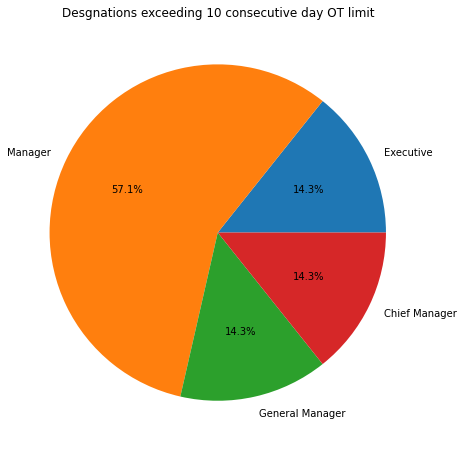

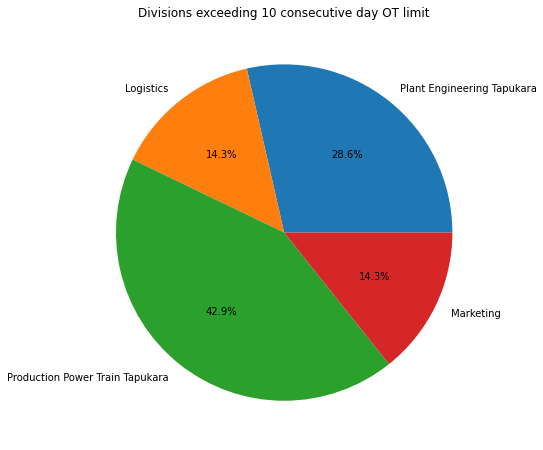

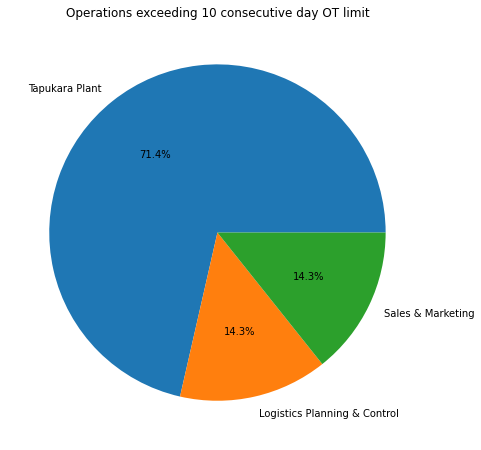

In [98]:
if len(dfff_10['Designation'])>1:
  dfff_10_list = list(set(dfff_10['Designation']))
  count_designation=[]
  count_designation=[list(dfff_10['Designation']).count(dfff_10_list[i]) for i in range(len(dfff_10_list))]
  x = dfff_10_list
  plt.figure(figsize=(10, 8))  
  plt.pie(count_designation,labels=x,autopct='%1.1f%%')
  plt.title('Desgnations exceeding 10 consecutive day OT limit')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('cons.png',bbox_inches="tight")


if len(dfff_10['Division'])>1:
  dfff_10_list = list(set(dfff_10['Division']))
  count_div=[]
  count_div=[list(dfff_10['Division']).count(dfff_10_list[i]) for i in range(len(dfff_10_list))]
  x = dfff_10_list
  plt.figure(figsize=(10, 8))  
  plt.pie(count_div,labels=x,autopct='%1.1f%%')
  plt.title('Divisions exceeding 10 consecutive day OT limit')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('cons2.png',bbox_inches="tight")

if len(dfff_10['Operation'])>1:
  dfff_10_list = list(set(dfff_10['Operation']))
  count_operation=[]
  count_operation=[list(dfff_10['Operation']).count(dfff_10_list[i]) for i in range(len(dfff_10_list))]
  x = dfff_10_list
  plt.figure(figsize=(10, 8))  
  plt.pie(count_operation,labels=x,autopct='%1.1f%%')
  plt.title('Operations exceeding 10 consecutive day OT limit')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('cons3.png',bbox_inches="tight")


In [68]:
# Sorting dataframe in descending order on basis of Total OT (User can get top x employees on basis of Total OT)
cont3=result.sort_values(by=['Total OT'], ascending=False)

In [69]:
cont3_hr_min=cont3.copy(deep=True)
l_time5=[]
for i in cont3_hr_min.index:
      minutes, hours = math.modf(cont3_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time5.append(ot_time)
cont3_hr_min.drop(['Total OT'],axis=1)
cont3_hr_min['Total OT']=l_time5

In [70]:
cont4=result_2.sort_values(by=['Total OT_Days'], ascending=False)

In [71]:
cont4_hr_min=cont4.copy(deep=True)
l_time6=[]
l_time6n=[]
for i in cont4_hr_min.index:
      minutes, hours = math.modf(cont4_hr_min['Total OT'][i])
      minutesn, hoursn = math.modf(cont4_hr_min['Average OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time6.append(ot_time)
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time6n.append(ot_timen)
cont4_hr_min.drop(['Total OT'],axis=1)
cont4_hr_min['Total OT']=l_time6
cont4_hr_min.drop(['Average OT'],axis=1)
cont4_hr_min['Average OT']=l_time6n

In [72]:
cont5=result_2.sort_values(by=['Total OT'], ascending=False)

In [73]:
cont5_hr_min=cont5.copy(deep=True)
l_time7=[]
l_time7n=[]
for i in cont5_hr_min.index:
      minutes, hours = math.modf(cont5_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time7.append(ot_time)
      minutesn, hoursn = math.modf(cont5_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time7n.append(ot_timen)
cont5_hr_min.drop(['Total OT'],axis=1)
cont5_hr_min['Total OT']=l_time7
cont5_hr_min.drop(['Average OT'],axis=1)
cont5_hr_min['Average OT']=l_time7n

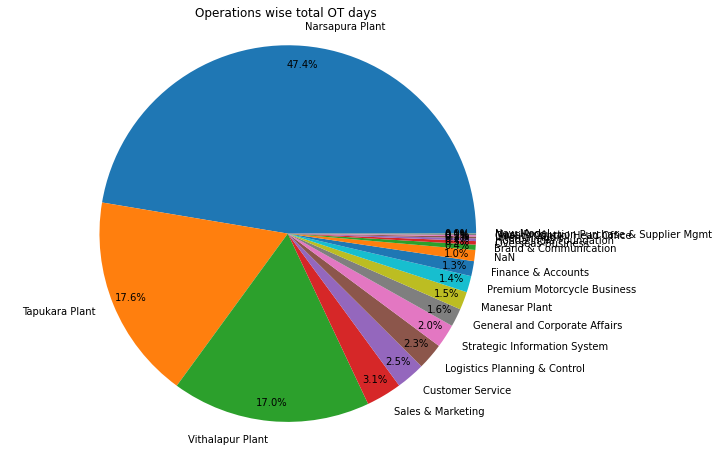

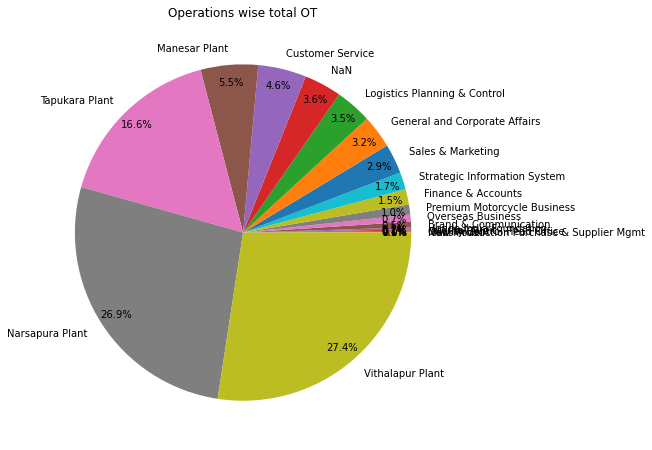

In [112]:
if len(cont4_hr_min['Operation'])>1:
  cont4_hr_min_list = list(cont4_hr_min['Operation'])
  cont4_hr_min_list2 = list(cont4_hr_min['Total OT_Days'])
  plt.figure(figsize=(10, 8))  
  plt.pie(cont4_hr_min_list2,labels=cont4_hr_min_list,autopct='%1.1f%%',pctdistance=0.9)
  plt.axis('equal')
  plt.title('Operations wise total OT days')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('opr.png',bbox_inches="tight")


if len(cont5_hr_min['Operation'])>1:
  cont5_hr_min_list = list(cont5_hr_min['Operation'])
  cont5_hr_min_list2 = list(cont5['Total OT'])
  plt.figure(figsize=(10, 8))  
  plt.pie(cont5_hr_min_list2[::-1],labels=cont5_hr_min_list[::-1], autopct='%1.1f%%',pctdistance=0.9)
  plt.title('Operations wise total OT')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('opr2.png',bbox_inches="tight")


In [75]:
cont6=result_3.sort_values(by=['Total OT_Days'], ascending=False)

In [76]:
cont6_hr_min=cont6.copy(deep=True)
l_time8=[]
l_time8n=[]
for i in cont6_hr_min.index:
      minutes, hours = math.modf(cont6_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time8.append(ot_time)

      minutesn, hoursn = math.modf(cont6_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time8n.append(ot_timen)
cont6_hr_min.drop(['Total OT'],axis=1)
cont6_hr_min['Total OT']=l_time8

cont6_hr_min.drop(['Average OT'],axis=1)
cont6_hr_min['Average OT']=l_time8n

In [77]:
cont7=result_3.sort_values(by=['Total OT'], ascending=False)

In [78]:
cont7_hr_min=cont7.copy(deep=True)
l_time9=[]
l_time9n=[]

for i in cont7_hr_min.index:
      minutes, hours = math.modf(cont7_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time9.append(ot_time)

      minutesn, hoursn = math.modf(cont7_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time9n.append(ot_timen)
cont7_hr_min.drop(['Total OT'],axis=1)
cont7_hr_min['Total OT']=l_time9

cont7_hr_min.drop(['Average OT'],axis=1)
cont7_hr_min['Average OT']=l_time9n

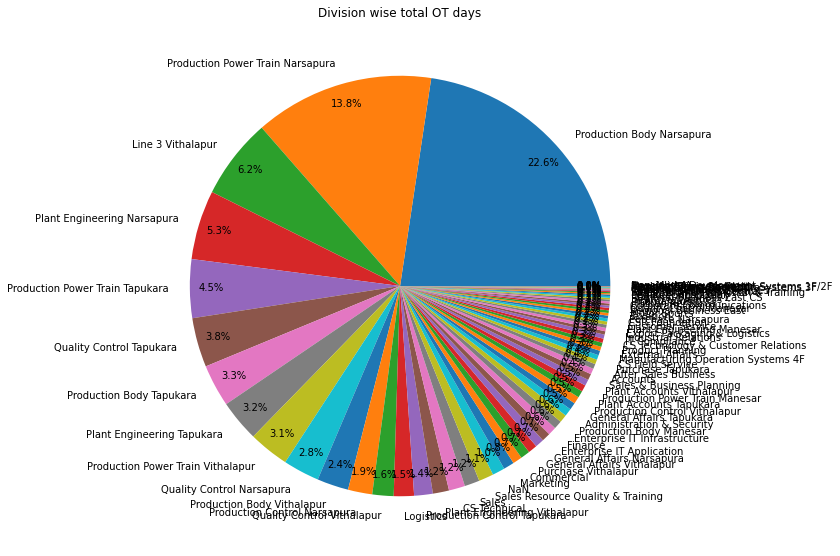

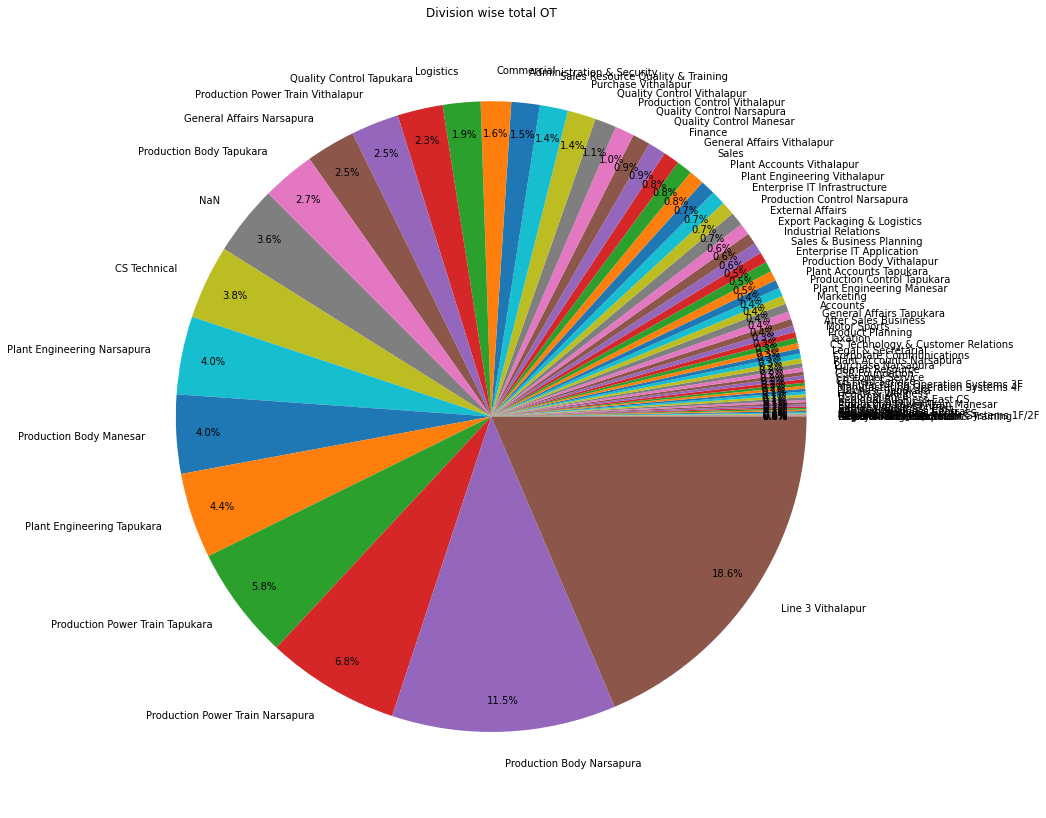

In [116]:
if len(cont6_hr_min['Division'])>1:
  cont6_hr_min_list = list(cont6_hr_min['Division'])
  cont6_hr_min_list2 = list(cont6_hr_min['Total OT_Days'])
  plt.figure(figsize=(15, 10))  
  plt.pie(cont6_hr_min_list2,labels=cont6_hr_min_list, autopct='%1.1f%%',pctdistance=0.9)
  plt.title('Division wise total OT days')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('div.png',bbox_inches="tight")


if len(cont7_hr_min['Division'])>1:
  cont7_hr_min_list = list(cont7_hr_min['Division'])
  cont7_hr_min_list2 = list(cont7['Total OT'])
  plt.figure(figsize=(15, 15))  
  plt.pie(cont7_hr_min_list2[::-1], labels=cont7_hr_min_list[::-1], autopct='%1.1f%%',pctdistance=0.9)
  plt.title('Division wise total OT')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('div2.png',bbox_inches="tight")


In [80]:
cont8=result_4.sort_values(by=['Total OT_Days'], ascending=False)

In [81]:
cont8_hr_min=cont8.copy(deep=True)
l_time10=[]
l_time10n=[]

for i in cont8_hr_min.index:
      minutes, hours = math.modf(cont8_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time10.append(ot_time)

      minutesn, hoursn = math.modf(cont8_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time10n.append(ot_timen)
cont8_hr_min.drop(['Total OT'],axis=1)
cont8_hr_min['Total OT']=l_time10

cont8_hr_min.drop(['Average OT'],axis=1)
cont8_hr_min['Average OT']=l_time10n

In [82]:
cont9=result_4.sort_values(by=['Total OT'], ascending=False)

In [83]:
cont9_hr_min=cont9.copy(deep=True)
l_time11=[]
l_time11n=[]

for i in cont9_hr_min.index:
      minutes, hours = math.modf(cont9_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time11.append(ot_time)

      minutesn, hoursn = math.modf(cont9_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time11n.append(ot_timen)
cont9_hr_min.drop(['Total OT'],axis=1)
cont9_hr_min['Total OT']=l_time11

cont9_hr_min.drop(['Average OT'],axis=1)
cont9_hr_min['Average OT']=l_time11n

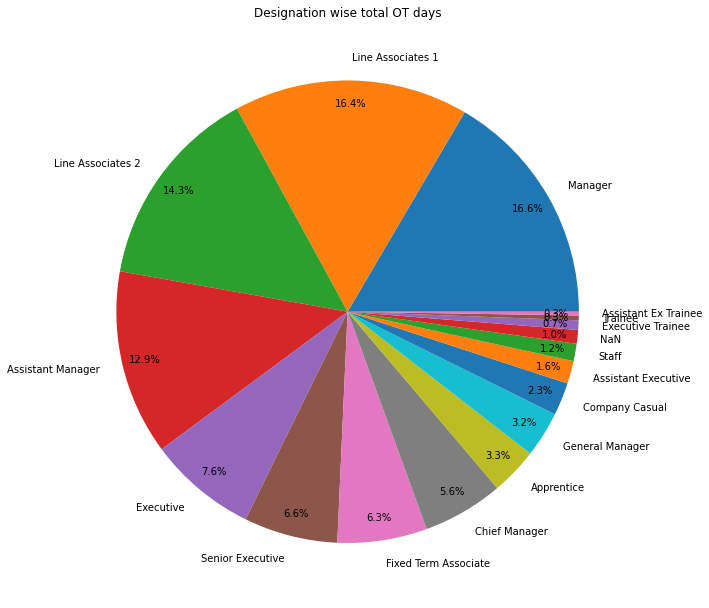

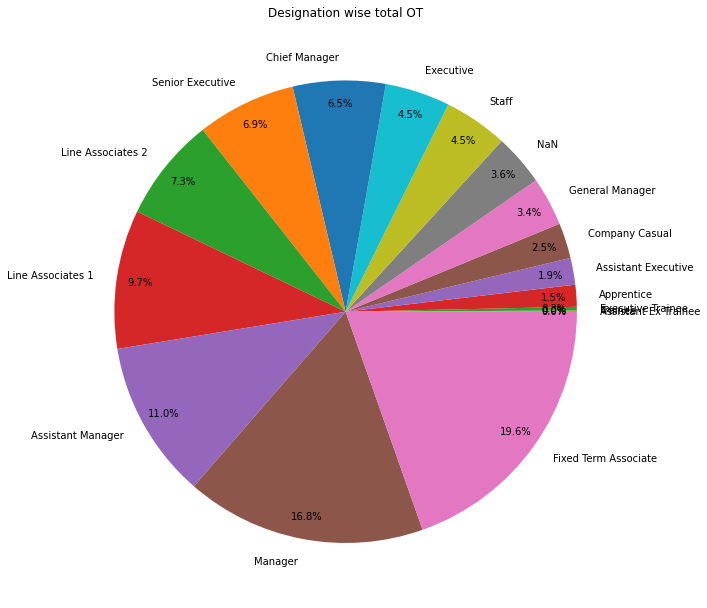

In [119]:
if len(cont8_hr_min['Designation'])>1:
  cont8_hr_min_list = list(cont8_hr_min['Designation'])
  cont8_hr_min_list2 = list(cont8_hr_min['Total OT_Days'])
  plt.figure(figsize=(15, 11))  
  plt.pie(cont8_hr_min_list2,labels=cont8_hr_min_list, autopct='%1.1f%%',pctdistance=0.9)
  plt.title('Designation wise total OT days')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('des.png',bbox_inches="tight")


if len(cont9_hr_min['Designation'])>1:
  cont9_hr_min_list = list(cont9_hr_min['Designation'])
  cont9_hr_min_list2 = list(cont9['Total OT'])
  plt.figure(figsize=(15, 11))  
  plt.pie(cont9_hr_min_list2[::-1],labels=cont9_hr_min_list[::-1], autopct='%1.1f%%',pctdistance=0.9)
  plt.title('Designation wise total OT')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('des2.png',bbox_inches="tight")


In [85]:
cont11=result_5.sort_values(by=['Total OT_Days'], ascending=False)

In [86]:
cont11_hr_min=cont11.copy(deep=True)
l_time13=[]
l_time13n=[]

for i in cont11_hr_min.index:
      minutes, hours = math.modf(cont11_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time13.append(ot_time)

      minutesn, hoursn = math.modf(cont11_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time13n.append(ot_timen)
cont11_hr_min.drop(['Total OT'],axis=1)
cont11_hr_min['Total OT']=l_time13

cont11_hr_min.drop(['Average OT'],axis=1)
cont11_hr_min['Average OT']=l_time13n

In [87]:
# Sorting dataframe in descending order on basis of Total OT (User can get top x employees on basis of Total OT)
cont10=result_5.sort_values(by=['Total OT'], ascending=False)

In [88]:
cont10_hr_min=cont10.copy(deep=True)
l_time12=[]
l_time12n=[]

for i in cont10_hr_min.index:
      minutes, hours = math.modf(cont10_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time12.append(ot_time)

      minutesn, hoursn = math.modf(cont10_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time12n.append(ot_timen)
cont10_hr_min.drop(['Total OT'],axis=1)
cont10_hr_min['Total OT']=l_time12

cont10_hr_min.drop(['Average OT'],axis=1)
cont10_hr_min['Average OT']=l_time12n

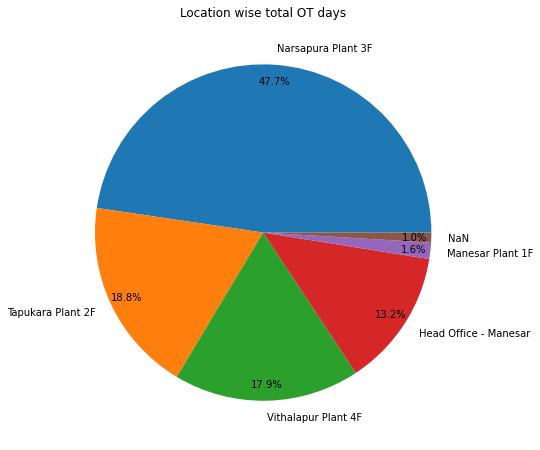

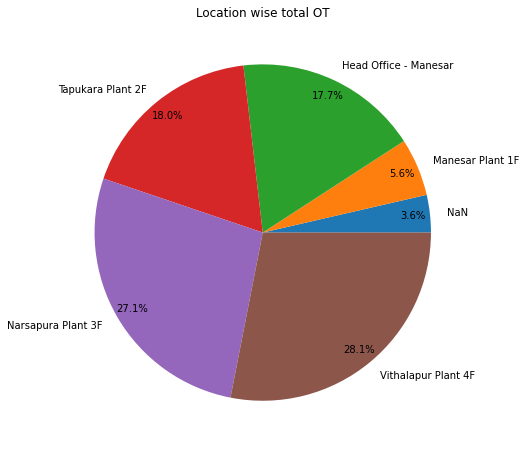

In [121]:
if len(cont11_hr_min['Location'])>1:
  cont11_hr_min_list = list(cont11_hr_min['Location'])
  cont11_hr_min_list2 = list(cont11_hr_min['Total OT_Days'])
  plt.figure(figsize=(10, 8))  
  plt.pie(cont11_hr_min_list2,labels=cont11_hr_min_list, autopct='%1.1f%%',pctdistance=0.9)
  plt.title('Location wise total OT days')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('loc.png',bbox_inches="tight")


if len(cont10_hr_min['Location'])>1:
  cont10_hr_min_list = list(cont10_hr_min['Location'])
  cont10_hr_min_list2 = list(cont10['Total OT'])
  plt.figure(figsize=(10, 8))  
  plt.pie(cont10_hr_min_list2[::-1],labels=cont10_hr_min_list[::-1], autopct='%1.1f%%',pctdistance=0.9)
  plt.title('Location wise total OT')
  plt.subplots_adjust(bottom = 0.15)
  plt.savefig('loc2.png',bbox_inches="tight")


In [90]:
cont13=result_6.sort_values(by=['Total OT_Days'], ascending=False)

In [91]:
cont13_hr_min=cont13.copy(deep=True)
l_time15=[]
l_time15n=[]

for i in cont13_hr_min.index:
      minutes, hours = math.modf(cont13_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time15.append(ot_time)

      minutesn, hoursn = math.modf(cont13_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time15n.append(ot_timen)
cont13_hr_min.drop(['Total OT'],axis=1)
cont13_hr_min['Total OT']=l_time15

cont13_hr_min.drop(['Average OT'],axis=1)
cont13_hr_min['Average OT']=l_time15n

In [92]:
# Sorting dataframe in descending order on basis of Total OT (User can get top x employees on basis of Total OT)
cont12=result_6.sort_values(by=['Total OT'], ascending=False)

In [93]:
cont12_hr_min=cont12.copy(deep=True)
l_time14=[]
l_time14n=[]

for i in cont12_hr_min.index:
      minutes, hours = math.modf(cont12_hr_min['Total OT'][i])
      minutes*=100
      ot_time = "{:.0f} Hr {:.0f} Min".format(hours, minutes)
      l_time14.append(ot_time)

      minutesn, hoursn = math.modf(cont12_hr_min['Average OT'][i])
      minutesn*=100
      ot_timen = "{:.0f} Hr {:.0f} Min".format(hoursn, minutesn)
      l_time14n.append(ot_timen)
cont12_hr_min.drop(['Total OT'],axis=1)
cont12_hr_min['Total OT']=l_time14

cont12_hr_min.drop(['Average OT'],axis=1)
cont12_hr_min['Average OT']=l_time14n

In [94]:
!pip install xlsxwriter
!pip install xlutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 19.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.6 MB/s 


In [95]:
from openpyxl import Workbook
import xlsxwriter
import os

def excelWriter():
  workbook = xlsxwriter.Workbook(r'OT_Analysis.xlsx')
  with pd.ExcelWriter(r'OT_Analysis.xlsx') as writer:
  #writer = r"C:\Users\Kartikey\Desktop\shorttt.xlsx"
  # write dataframe to excel
      df_final_hr_min.to_excel(writer,sheet_name='OT')
      result_hr_min.to_excel(writer,sheet_name='Total_OT')
      cont2_hr_min.to_excel(writer,sheet_name='Highest_Total_OT_Days')
      cont3_hr_min.to_excel(writer,sheet_name='Highest_Total_OT')
      l_diff_hr_min.to_excel(writer,sheet_name='Exceeding OT Limit')
      dfff_10.to_excel(writer,sheet_name='Exceeding 10 cons. OT days')
      l_double_shift.to_excel(writer,sheet_name='Double shift')
      cont4_hr_min.to_excel(writer,sheet_name='Operation_Highest_Total_OT_Days')
      cont5_hr_min.to_excel(writer,sheet_name='Operation_Highest_Total_OT')
      cont6_hr_min.to_excel(writer,sheet_name='Division_Highest_Total_OT_Days')
      cont7_hr_min.to_excel(writer,sheet_name='Division_Highest_Total_OT')
      cont8_hr_min.to_excel(writer,sheet_name='Desig_Highest_Total_OT_Days')
      cont9_hr_min.to_excel(writer,sheet_name='Desig_Highest_Total_OT')
      cont11_hr_min.to_excel(writer,sheet_name='Location_Highest_Total_OT_Days')
      cont10_hr_min.to_excel(writer,sheet_name='Location_Highest_Total_OT')
      cont13_hr_min.to_excel(writer,sheet_name='Dept_Highest_Total_OT_Days')
      cont12_hr_min.to_excel(writer,sheet_name='Dept_Highest_Total_OT')

with ft.ThreadPoolExecutor() as executor:
  executor.submit(excelWriter).result()

In [123]:
from openpyxl import Workbook
import xlsxwriter
import os

workbook = xlsxwriter.Workbook('Visualization of OT_Analysis.xlsx')
worksheet = workbook.add_worksheet('Double Shift')
worksheet2 = workbook.add_worksheet('OT Limit')
worksheet3 = workbook.add_worksheet('Consecutive 10 days OT')
worksheet4 = workbook.add_worksheet('operation')
worksheet5 = workbook.add_worksheet('division')
worksheet6 = workbook.add_worksheet('designation')
worksheet7 = workbook.add_worksheet('location')

worksheet.insert_image('A2', 'doubleshiftgraph.png')
worksheet.insert_image('K2', 'doubleshiftgraph2.png')
worksheet.insert_image('A40', 'doubleshiftgraph3.png')
worksheet.insert_image('K40', 'doubleshiftgraph4.png')
worksheet2.insert_image('A2', 'otlimit.png')
worksheet2.insert_image('R2', 'otlimit2.png')
worksheet3.insert_image('A2', 'cons.png')
worksheet3.insert_image('R2', 'cons2.png')
worksheet3.insert_image('A40', 'cons3.png')
worksheet4.insert_image('A2', 'opr.png')
worksheet4.insert_image('R2', 'opr.png')
worksheet5.insert_image('A2', 'div.png')
worksheet5.insert_image('X2', 'div2.png')
worksheet6.insert_image('A2', 'des.png')
worksheet6.insert_image('X2', 'des2.png')
worksheet7.insert_image('A2', 'loc.png')
worksheet7.insert_image('R2', 'loc2.png')
workbook.close()

In [97]:
# from openpyxl import load_workbook
# wb2 = load_workbook('punch_short.xlsx')
# wb2.create_sheet('s',1)
# wb2.save('punch_short.xlsx')
